# Prepare for modelling

In [1]:
import pandas as pd 
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
import mlflow
from modeling.config import EXPERIMENT_NAME
TRACKING_URI = open("../.mlflow_uri").read().strip()


from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.preprocessing import power_transform
from sklearn.preprocessing import PowerTransformer
from scipy import stats
#>>> print(power_transform(data, method='box-cox'))
import statsmodels.api as sm

In [2]:
# read data
df = pd.read_csv('../data/Featureselection03.csv')
df.head()

,EntryDate,AB.FMS.act.tPh,AB.FTS.act.dgC,DDM.AFTCL.act.m,DDM.FWDCL.act.m,DDM.MIDPS.act.m,DDM.MIDSB.act.m,HFO.GME.act.nodim,ME.EFF.act.PRC,ME.FMS.act.tPh,...,Heading_Dir_deg_daily,True_Wind_Speed_mPs_daily,True_Wind_Dir_deg_daily,Wave_Height_m_daily,True_Wave_Dir_deg_daily,trip_id,Power_EM_predict,DDM.TRIM.act.m,DDM.DRAFT.act.m,DDM.HEEL.act.m
0,2021-05-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,80.0,6.7,109.0,0.5,289.0,1,14599.69,1.021,0.1276,0.2552
1,2021-05-31 00:01:00,0.003108,82.858482,13.309999,14.788999,13.924999,13.587000,1.0,50.766113,3.353553,...,80.0,6.7,109.0,0.5,289.0,2,14599.69,1.021,0.1276,0.2552
2,2021-05-31 00:02:00,0.001970,82.832756,13.444999,14.363999,13.320999,13.378999,1.0,50.982193,3.305582,...,80.0,6.7,109.0,0.5,289.0,2,14599.69,1.021,0.1276,0.2552
3,2021-05-31 00:03:00,0.000000,82.795395,13.381999,14.321000,14.242000,13.584000,1.0,51.326881,3.288588,...,80.0,6.7,109.0,0.5,289.0,2,14599.69,1.021,0.1276,0.2552
4,2021-05-31 00:04:00,0.000000,82.884254,13.365999,14.745000,14.094998,13.596999,1.0,52.311672,3.239272,...,80.0,6.7,109.0,0.5,289.0,2,14599.69,1.021,0.1276,0.2552


In [3]:
# read list with feature importance
data_log = pd.read_csv('../data/Capstone_features_Features.csv')
data_log.head()

,VarName,F_Imp_new,ModelImportance
0,LM1.plc_skewtime.act.s,3,3
1,LM1.plc_skewtime.max.s,3,3
2,LM1.plc_uptime.act.s,3,3
3,LM1.plc_cpuload.avg_5s.PRC,3,3
4,LM1.plc_timeBalance.act.s,3,3


In [4]:
# create list of important features (feature importance < 3)
list_imp_feat = list(data_log[data_log['ModelImportance'] < 3]['VarName'])
len(list_imp_feat)

18

In [5]:
df_model = df[list_imp_feat].copy()

In [6]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211679 entries, 0 to 211678
Data columns (total 18 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ME.FMS.act.tPh           210961 non-null  float64
 1   ME.FTS.act.dgC           210961 non-null  float64
 2   HFO.GME.act.nodim        210961 non-null  float64
 3   V.COG.act.deg            210885 non-null  float64
 4   V.SOG.act.kn             210885 non-null  float64
 5   V.RUA.act.deg            210885 non-null  float64
 6   V.GPSLAT.act.deg         210885 non-null  float64
 7   V.GPSLON.act.deg         210885 non-null  float64
 8   WEA.WDT.act.deg          210814 non-null  float64
 9   WEA.WST.act.mPs          210884 non-null  float64
 10  V.SLPOG.act.PRC          136969 non-null  float64
 11  ME.SFCI.act.gPkWh        136929 non-null  float64
 12  DDM.TRIM.act.m           211679 non-null  float64
 13  DDM.DRAFT.act.m          211679 non-null  float64
 14  pass

In [7]:
df_model['V.SLPOG.act.PRC'].fillna(0,inplace=True)
df_model['ME.SFCI.act.gPkWh'].fillna(0,inplace=True)

In [8]:
df_model['A.SOG.next.kn'] = (df_model['V.SOG.act.kn'].shift(-1) - df_model['V.SOG.act.kn'])
df_model['A.SOG.next.kn'].fillna(df_model['V.SOG.act.kn'], inplace=True)
df_model['A.SOG.next.kn'].describe()

count    210885.000000
mean          0.000006
std           0.131817
min         -10.254501
25%          -0.016001
50%           0.000000
75%           0.019000
max           9.872501
Name: A.SOG.next.kn, dtype: float64

In [9]:
df_model.dropna(inplace=True)

In [10]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180149 entries, 1 to 211678
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ME.FMS.act.tPh           180149 non-null  float64
 1   ME.FTS.act.dgC           180149 non-null  float64
 2   HFO.GME.act.nodim        180149 non-null  float64
 3   V.COG.act.deg            180149 non-null  float64
 4   V.SOG.act.kn             180149 non-null  float64
 5   V.RUA.act.deg            180149 non-null  float64
 6   V.GPSLAT.act.deg         180149 non-null  float64
 7   V.GPSLON.act.deg         180149 non-null  float64
 8   WEA.WDT.act.deg          180149 non-null  float64
 9   WEA.WST.act.mPs          180149 non-null  float64
 10  V.SLPOG.act.PRC          180149 non-null  float64
 11  ME.SFCI.act.gPkWh        180149 non-null  float64
 12  DDM.TRIM.act.m           180149 non-null  float64
 13  DDM.DRAFT.act.m          180149 non-null  float64
 14  pass

<AxesSubplot:>

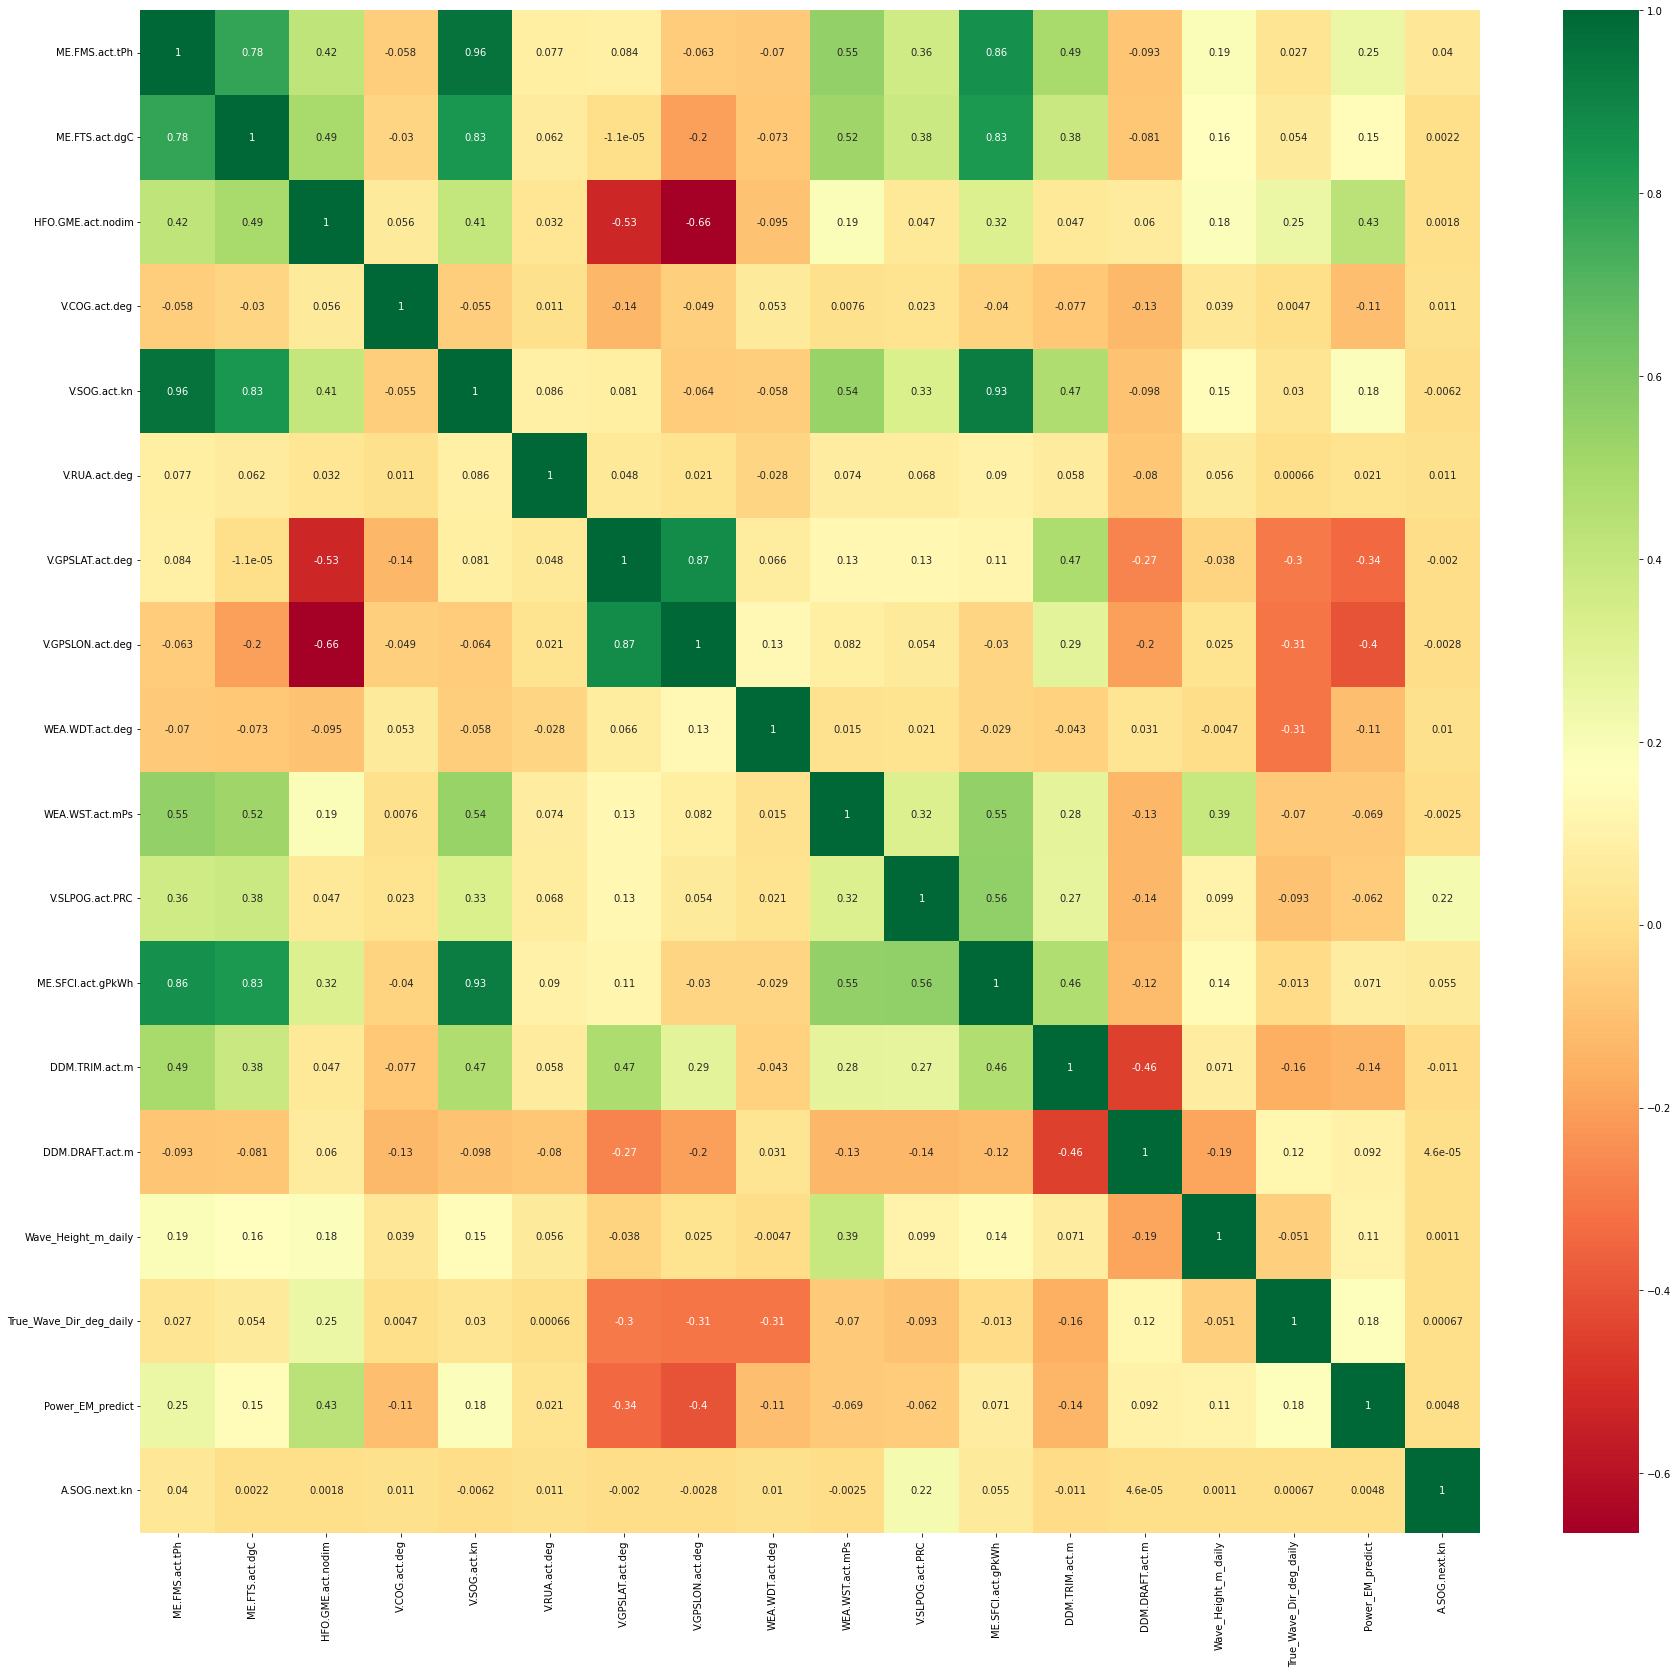

In [11]:
plt.figure(figsize = (30,28))
sns.heatmap(df_model.corr(), annot = True, cmap = 'RdYlGn')

In [12]:
X = df_model.drop(['ME.FMS.act.tPh'], axis = 1)
y = df_model['ME.FMS.act.tPh']

In [13]:
X.rename(columns={'passage_type_Europe<13.5kn': 'passage_type_Europe_smaller_13.5kn', 'passage_type_Europe>13.5kn': 'passage_type_Europe_greater_13.5kn',\
    'passage_type_SouthAmerica<13.5kn': 'passage_type_SouthAmerica_smaller_13.5kn', 'passage_type_SouthAmerica>13.5kn': 'passage_type_SouthAmerica_greater_13.5kn'}, inplace=True)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = X['passage_type'], test_size = 0.1, random_state = 42)

As passage_type is the only object type, get_dummies will only create dummies for passage_type.

In [15]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

In [16]:
runmlflow = False

# setting the MLFlow connection and experiment
if runmlflow == True:
    mlflow.set_tracking_uri(TRACKING_URI)
    mlflow.set_experiment(EXPERIMENT_NAME)
    mlflow.start_run(run_name='Stacking (Poly, RF_Hyper)') # CHANGE!
    run = mlflow.active_run()

---

## Model

In [17]:
RSEED = 42

In [139]:
estimators = [
    ('rfh', make_pipeline(MinMaxScaler(), RandomForestRegressor(criterion= 'squared_error',
                                            max_depth= 40, 
                                            max_features= 'auto',
                                            max_leaf_nodes= 7000, 
                                            min_samples_split= 20,
                                            n_estimators= 100,
                                            random_state=RSEED))),                                    #    ('xgb', make_pipeline(MinMaxScaler(), XGBRegressor(seed = RSEED))),
    ('plr', make_pipeline(PolynomialFeatures(degree=2), MinMaxScaler() , LinearRegression())),
    ]
reg = StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor(random_state=RSEED))


In [140]:
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
y_pred_train = reg.predict(X_train)

In [ ]:
y_pred2 = y_pred.copy()
y_pred2_train = y_pred_train.copy()

y_pred2[y_pred2 < 0.013509] = 0
y_pred2_train[y_pred2_train < 0.013509] = 0 #0.013509

print('RMSE train: ', mean_squared_error(y_train, y_pred2_train, squared= False))
rmse_train = mean_squared_error(y_train, y_pred2_train, squared= False)
print('RMSE test: ', mean_squared_error(y_test, y_pred2, squared= False))
rmse_test = mean_squared_error(y_test, y_pred2, squared= False)

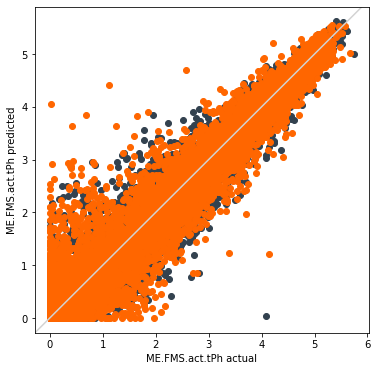

In [91]:
fig=plt.figure(figsize=(6, 6))
plt.axline([1, 1], [2, 2],color='lightgrey')
plt.scatter(y_train, y_pred2_train, color ='#33424F')
plt.scatter(y_test, y_pred2, color = '#FF6600')
#plt.xticks(np.arange(0,501,100));
#plt.yticks(np.arange(0,501,100));
plt.xlabel("ME.FMS.act.tPh actual");
plt.ylabel("ME.FMS.act.tPh predicted");
#plt.xlim(0, 450);
#plt.ylim(0, 450);

In [92]:
residuals_train = y_pred2_train - y_train
residuals_test = y_pred2 - y_test

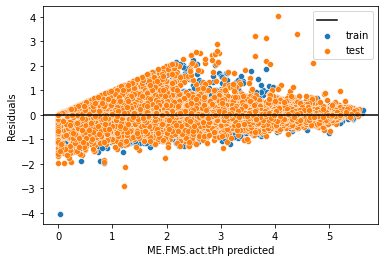

In [93]:
sns.scatterplot(x = y_pred2_train, y = residuals_train)
sns.scatterplot(x = y_pred2, y = residuals_test)
plt.axhline(y = 0, color = 'black')
plt.xlabel("ME.FMS.act.tPh predicted");
plt.ylabel("Residuals");
plt.legend(labels=['', 'train', 'test'])

In [150]:
#seting parameters that should be logged on MLFlow
#these parameters were used in feature engineering (inputing missing values)
#or parameters of the model (fit_intercept for Linear Regression model)
params = {
      "features drop": 'EntryDate,Date_daily, Type_daily, TI.LOC.act.ts, WEA.WDR.act.deg, WEA.WSR.act.mPs, WEA.WDTV.act.deg, trip_id, LS.GME.act.nodim, V.WD.act.m',
      "explanation": 'correlated features with <0.95 where dropped',
      "csv used": 'Featureselection03.csv',
      "NaN handling": 'V.SLPOG.act.PRC and ME.SFCI.act.gPkWh filled with 0, rest dropped by row',
      'Shape' : df.shape,
      'Scaler' : 'MinMaxScaler'
  }

In [151]:
if runmlflow == True:
    #logging params to mlflow
    mlflow.log_params(params)
    #setting tags
    mlflow.set_tag("running_from_jupyter", "True")
    #logging metrics
    mlflow.log_metric("train-" + "RMSE", rmse_train)
    mlflow.log_metric("test-" + "RMSE", rmse_test)
    # logging the model to mlflow will not work without a AWS Connection setup.. too complex for now
    # but possible if running mlflow locally
    # mlflow.log_artifact("../models")
    # mlflow.sklearn.log_model(reg, "model")
    mlflow.end_run()